In [1]:
import os
import ot
from ot import emd2, emd  # POT package for EMD computation
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.9'
import jax
import jax.numpy as jnp
import numpy as np
from jax import random, grad, vmap, jit, hessian
from jax.example_libraries import optimizers
from jax.experimental.ode import odeint
from jax.nn import relu, elu
# from jax.ops import index_update, index
from jax import lax
from jax.flatten_util import ravel_pytree
from jax import device_get

import itertools
from functools import partial
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import time
import scipy.optimize as sp_opt
import pandas as pd
import numpy as np
from scipy.stats import ortho_group
from scipy.linalg import sqrtm
import flax
import flax.linen as nn
from matplotlib.ticker import FuncFormatter

from scipy.interpolate import griddata
from scipy.sparse import csr_matrix
%matplotlib inline
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [2]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)
OUTPUT_SEED = 0xC0FFEE

/tmp/ipykernel_1108778/2678599469.py:2: DeprecationWarning: jax.lib.xla_bridge.get_backend is deprecated; use jax.extend.backend.get_backend.
  print(xla_bridge.get_backend().platform)


gpu


In [9]:
def read_csv_no_headers(file_path, column_names=None, nrows=100000, skip_header=True):
    """
    Read a CSV file that may contain a header and assign custom column names.
    
    Parameters:
    file_path (str): Path to the CSV file.
    column_names (list, optional): List of column names to assign. If None, default names will be used.
    nrows (int, optional): Number of rows to read from the CSV file.
    skip_header (bool, optional): If True, skip the first row (header).
    
    Returns:
    pd.DataFrame: DataFrame with numeric data and assigned column names.
    jnp.array: JAX array containing the same data as float32.
    """
    if column_names is None:
        column_names = [f'Column{i+1}' for i in range(2)]
    
    skiprows = 1 if skip_header else 0

    df = pd.read_csv(file_path, header=None, names=column_names, nrows=nrows, skiprows=skiprows)
    
    df_numeric = df.astype(float)
    
    np_array = df_numeric.to_numpy()
    jax_array = jnp.array(np_array, dtype=jnp.float32)
    
    return df_numeric, jax_array


file_path = "measure_gen.csv"

df1, target_data = read_csv_no_headers(file_path)

In [10]:
class TrainingDataGenerator: 
    def __init__(self, n_dict=3, batch_size=500, rng_key=random.PRNGKey(5923)):
        'Initialization'
        self.n_dict = n_dict
        self.N = batch_size
        self.data_set=jnp.zeros([n_dict, self.N, 4]) 
        self.key = rng_key
        self.key, subkey = random.split(self.key)
        for i in range(n_dict):
            xx = SourceGenerator(rng_key=subkey, size = self.N)
            self.data_set=self.data_set.at[i, :, 0:2].set(xx)
            self.key, subkey = random.split(self.key)

            yy = TargetGenerator(rng_key = subkey, size = self.N)
            self.data_set=self.data_set.at[i, :, 2:4].set(yy) 
     
        self.batch_size = batch_size

    def __iter__(self):
        self.current = 0
        return self
        
    def __next__(self):
        self.key, subkey = random.split(self.key)
        inputs, outputs = self.__data_generation(subkey)
        self.current += 1
        return inputs, outputs

    
    def __getitem__(self, index):
        'Generate one batch of data'
        self.key, subkey = random.split(self.key) 
        inputs, outputs= self.__data_generation(subkey) 
        return inputs, outputs

    @partial(jit, static_argnums=(0,)) 
    def __data_generation(self, key):
        'Generates data containing batch_size samples'
        key1, key2, permute_key = random.split(key, 3)
        inputs = jnp.zeros([self.n_dict, self.N, 2])
        outputs = jnp.zeros([self.n_dict, self.N, 2])
        
        for i in range(self.n_dict):
            inputs = inputs.at[i, :, :].set(SourceGenerator(rng_key = key1, size = self.N))
            outputs = outputs.at[i,:,:].set(TargetGenerator(rng_key = key2, size = self.N))
        return inputs, outputs

def SourceGenerator(rng_key = random.PRNGKey(5931), size = 1000):
    sample_source = random.uniform(rng_key, shape = [size, 2])
    return sample_source

def TargetGenerator(rng_key = random.PRNGKey(5931), size = 1000):
    total_rows = target_data.shape[0]
    batch_size = min(total_rows, size)
    sample_indices = random.choice(rng_key, jnp.arange(total_rows), shape = (batch_size,), replace = False)
    return target_data[sample_indices]

In [11]:
class ResidualBlock(nn.Module):
    """A residual block with two dense layers and PReLU activation."""
    features: int
    negative_slope_init: float = 0.25

    @nn.compact
    def __call__(self, x):
        residual = x
        x = nn.Dense(self.features)(x)
        x = nn.PReLU(negative_slope_init=self.negative_slope_init)(x)  
        x = nn.Dense(self.features)(x)
        x = nn.PReLU()(x) 
        x = nn.Dense(self.features)(x)
        x = nn.PReLU()(x)          
        x = nn.Dense(self.features)(x)
        x = nn.PReLU()(x) 
        return x + residual

class ResNet(nn.Module):
    """ResNet with PReLU activations."""
    n_blocks: int
    features: int
    output_dim: int
    negative_slope_init: float = 0.25

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(self.features)(x)
        x = nn.PReLU(negative_slope_init=self.negative_slope_init)(x)  

        for _ in range(self.n_blocks):
            x = ResidualBlock(self.features, self.negative_slope_init)(x)

        x = nn.Dense(self.output_dim)(x)
        return x

In [12]:
class DPNet:
    def __init__(self, in_dim, n_blocks, features, output_dim, rng_key=random.PRNGKey(3984)):
        self.model = ResNet(n_blocks, features, output_dim, negative_slope_init=0.25)
        self.rng_key = rng_key 
        params = self.model.init(self.rng_key, jnp.ones((1, in_dim)))
        key1, key2 = random.split(self.rng_key, 2)


        self.opt_init, self.opt_update, self.get_params = optimizers.adam(
            optimizers.exponential_decay(1e-3, decay_steps=500, decay_rate=0.95))
        self.opt_state = self.opt_init(params)

       
        _, self.unravel_params = ravel_pytree(params)
        self.itercount_pretrain = itertools.count()
        self.itercount = itertools.count()
        
        self.loss_log = [] 
        self.emdgt_log = [] 
        self.w2_deepparticle_log = []  
        self.w2_emd_log = []  
        self.gamma_log = []
        self.it_log = []
        
    

    def distance_matrix(self, f, y):
        f1 = jnp.expand_dims(f, 2)
        y1 = jnp.expand_dims(y, 1)
        return jnp.sum(jnp.square(f1 - y1), 3)

    
    def DP_loss_mean(self, params, batch, gamma):
        x, y = batch
        f = self.predict(params, x) 
        W2 = 0.5*jnp.sum(jnp.sum(self.distance_matrix(f, y)*gamma,-1),-1)
        W = jnp.sqrt(W2)
        return jnp.mean(W)

    
    def emd_loss_mean(self, params, batch):
        x, y = batch
        f = self.predict(params, x)
        cost = 0.5*jnp.sum((f-x)**2,-1)
        cost1 = jnp.mean(cost,-1)
        cost1 = jnp.sqrt(cost1)
        return jnp.mean(cost1)


    def compute_identity_loss(self, params, batch):
        x,_=batch
        f = self.predict(params, x)
        y = exact_transport_map(x)
        loss = jnp.mean((f-y)**2)
        return loss

    
    def compute_full_loss(self, params, batch, gamma, lambda1):
        """
        Compute the full loss by combining the DP loss and EMD loss.
        The EMD loss is computed using NumPy arrays.
        """            
        DPloss = self.DP_loss_mean(params, batch, gamma)
        EMDloss = self.emd_loss_mean(params, batch)
        total_loss = DPloss + lambda1 * EMDloss
        return total_loss



    #@partial(jit, static_argnums=(0,))  
    def step_params(self, i, opt_state, batch, gamma, lambda1):
        params = self.get_params(opt_state)
        g = grad(self.compute_full_loss)(params, batch, gamma, lambda1)
        return self.opt_update(i, g, opt_state)
        

    def cal_gamma(self, f, y, gamma):
        batch_size = f.shape[1]
        M = self.distance_matrix(f,y)
        weights = np.ones((batch_size,))*1.0/batch_size
        for ib in range(y.shape[0]):
            newvalgamma = ot.lp.emd(weights,weights, np.array(M[ib, :, :]))
            gamma = gamma.at[ib, :, :].set(newvalgamma) 
        return gamma

    def renew_batch(self, data_iter):
        batch = next(data_iter) 
        data_shape = batch[0].shape
        return batch


    def train(self, dataset, nIter=500, n_batch_renew=5, n_gamma_renew=5, n_print = 1, lambda1=0.9):
        data_iter = iter(dataset)
        pbar = trange(nIter, smoothing=0) 
        for it in pbar:
            
            if it % n_batch_renew == 0:
                batch = self.renew_batch(data_iter)
                data_shape = batch[0].shape
                gamma_fy = jnp.ones((data_shape[0], data_shape[1], data_shape[1])) * (1.0 / data_shape[1]) 
                

            if it % n_gamma_renew == 0: 
                x, y = jax.device_get(batch)
                params = self.get_params(self.opt_state) 
                f = jax.device_get(self.predict(params, x))  
                gamma_fy = self.cal_gamma(f,y,gamma_fy)


            self.opt_state = self.step_params(next(self.itercount), self.opt_state, batch, gamma_fy, lambda1)

            if it % n_print == 0:
                params = self.get_params(self.opt_state)
                DPloss = self.DP_loss_mean(params, batch, gamma_fy)
                EMDloss = self.emd_loss_mean(params, batch)

                
                total_loss= self.compute_full_loss(params, batch, gamma_fy, lambda1)
                self.loss_log.append(total_loss)
                self.w2_deepparticle_log.append(DPloss)
                self.w2_emd_log.append(EMDloss)
                self.it_log.append(it)
                
                pbar.refresh()
                pbar.set_description("Tot: %.1e, DP: %.1e, EMD: %.1e" % (total_loss, DPloss, EMDloss))
                
        x, y = batch
        params = self.get_params(self.opt_state)
        f=self.predict(params, x)
        return batch, f

    @partial(jit, static_argnums=(0,))
    def predict(self, params, x):
        pred = self.model.apply(params, x) + x[:,:,:2]
        return pred

In [13]:

key = random.PRNGKey(0)


batch_size = 3000
predict_size = 20000

m_in = 2 
m_out = 2
m_hidden = 64
n_blocks = 4


lambda1 = 0.3

key, key_s = random.split(key)
dataset = TrainingDataGenerator(batch_size = batch_size, rng_key = key_s, n_dict = 5)

model = DPNet(m_in, n_blocks, m_hidden, m_out, key)

tempout = model.train(dataset, nIter=2000, n_batch_renew=10, n_gamma_renew=10, n_print = 10, lambda1 = lambda1) 

  0%|                                                                                                       | 0/2000 [00:00<?, ?it/s]/home/lileduo/anaconda3/envs/venv/lib/python3.10/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
Tot: 3.3e+00, DP: 3.1e+00, EMD: 8.4e-01:   0%|▎                                                    | 10/2000 [00:09<30:03,  1.10it/s]/home/lileduo/anaconda3/envs/venv/lib/python3.10/site-packages/ot/lp/__init__.py:361: UserWarning: numItermax reached before optimality. Try to increase numItermax.
  result_code_string = check_result(result_code)
Tot: 1.3e+00, DP: 2.8e-01, EMD: 3.3e+00: 100%|███████████████████████████████████████████████████| 2000/2000 [18:03<00:00,  1.85it/s]


In [14]:
def hist2dplot(x, y, ax1, labels=['1', '2'], xylims=None, vmin=None, vmax=None):
    if xylims is None:
        H, xedges, yedges = np.histogram2d(x, y, 20, density=True)
    else:
        H, xedges, yedges = np.histogram2d(x, y, 20, density=True, 
                                         range=[[xylims[0], xylims[1]], 
                                               [xylims[2], xylims[3]]])
    H = H.T
    cax = ax1.pcolormesh(xedges, yedges, H, vmin=vmin, vmax=vmax)
    pbar = plt.colorbar(cax, ax=ax1)
    ax1.set_xlabel(labels[0])
    ax1.set_ylabel(labels[1])
    ax1.grid()
    
    return H, xedges, yedges

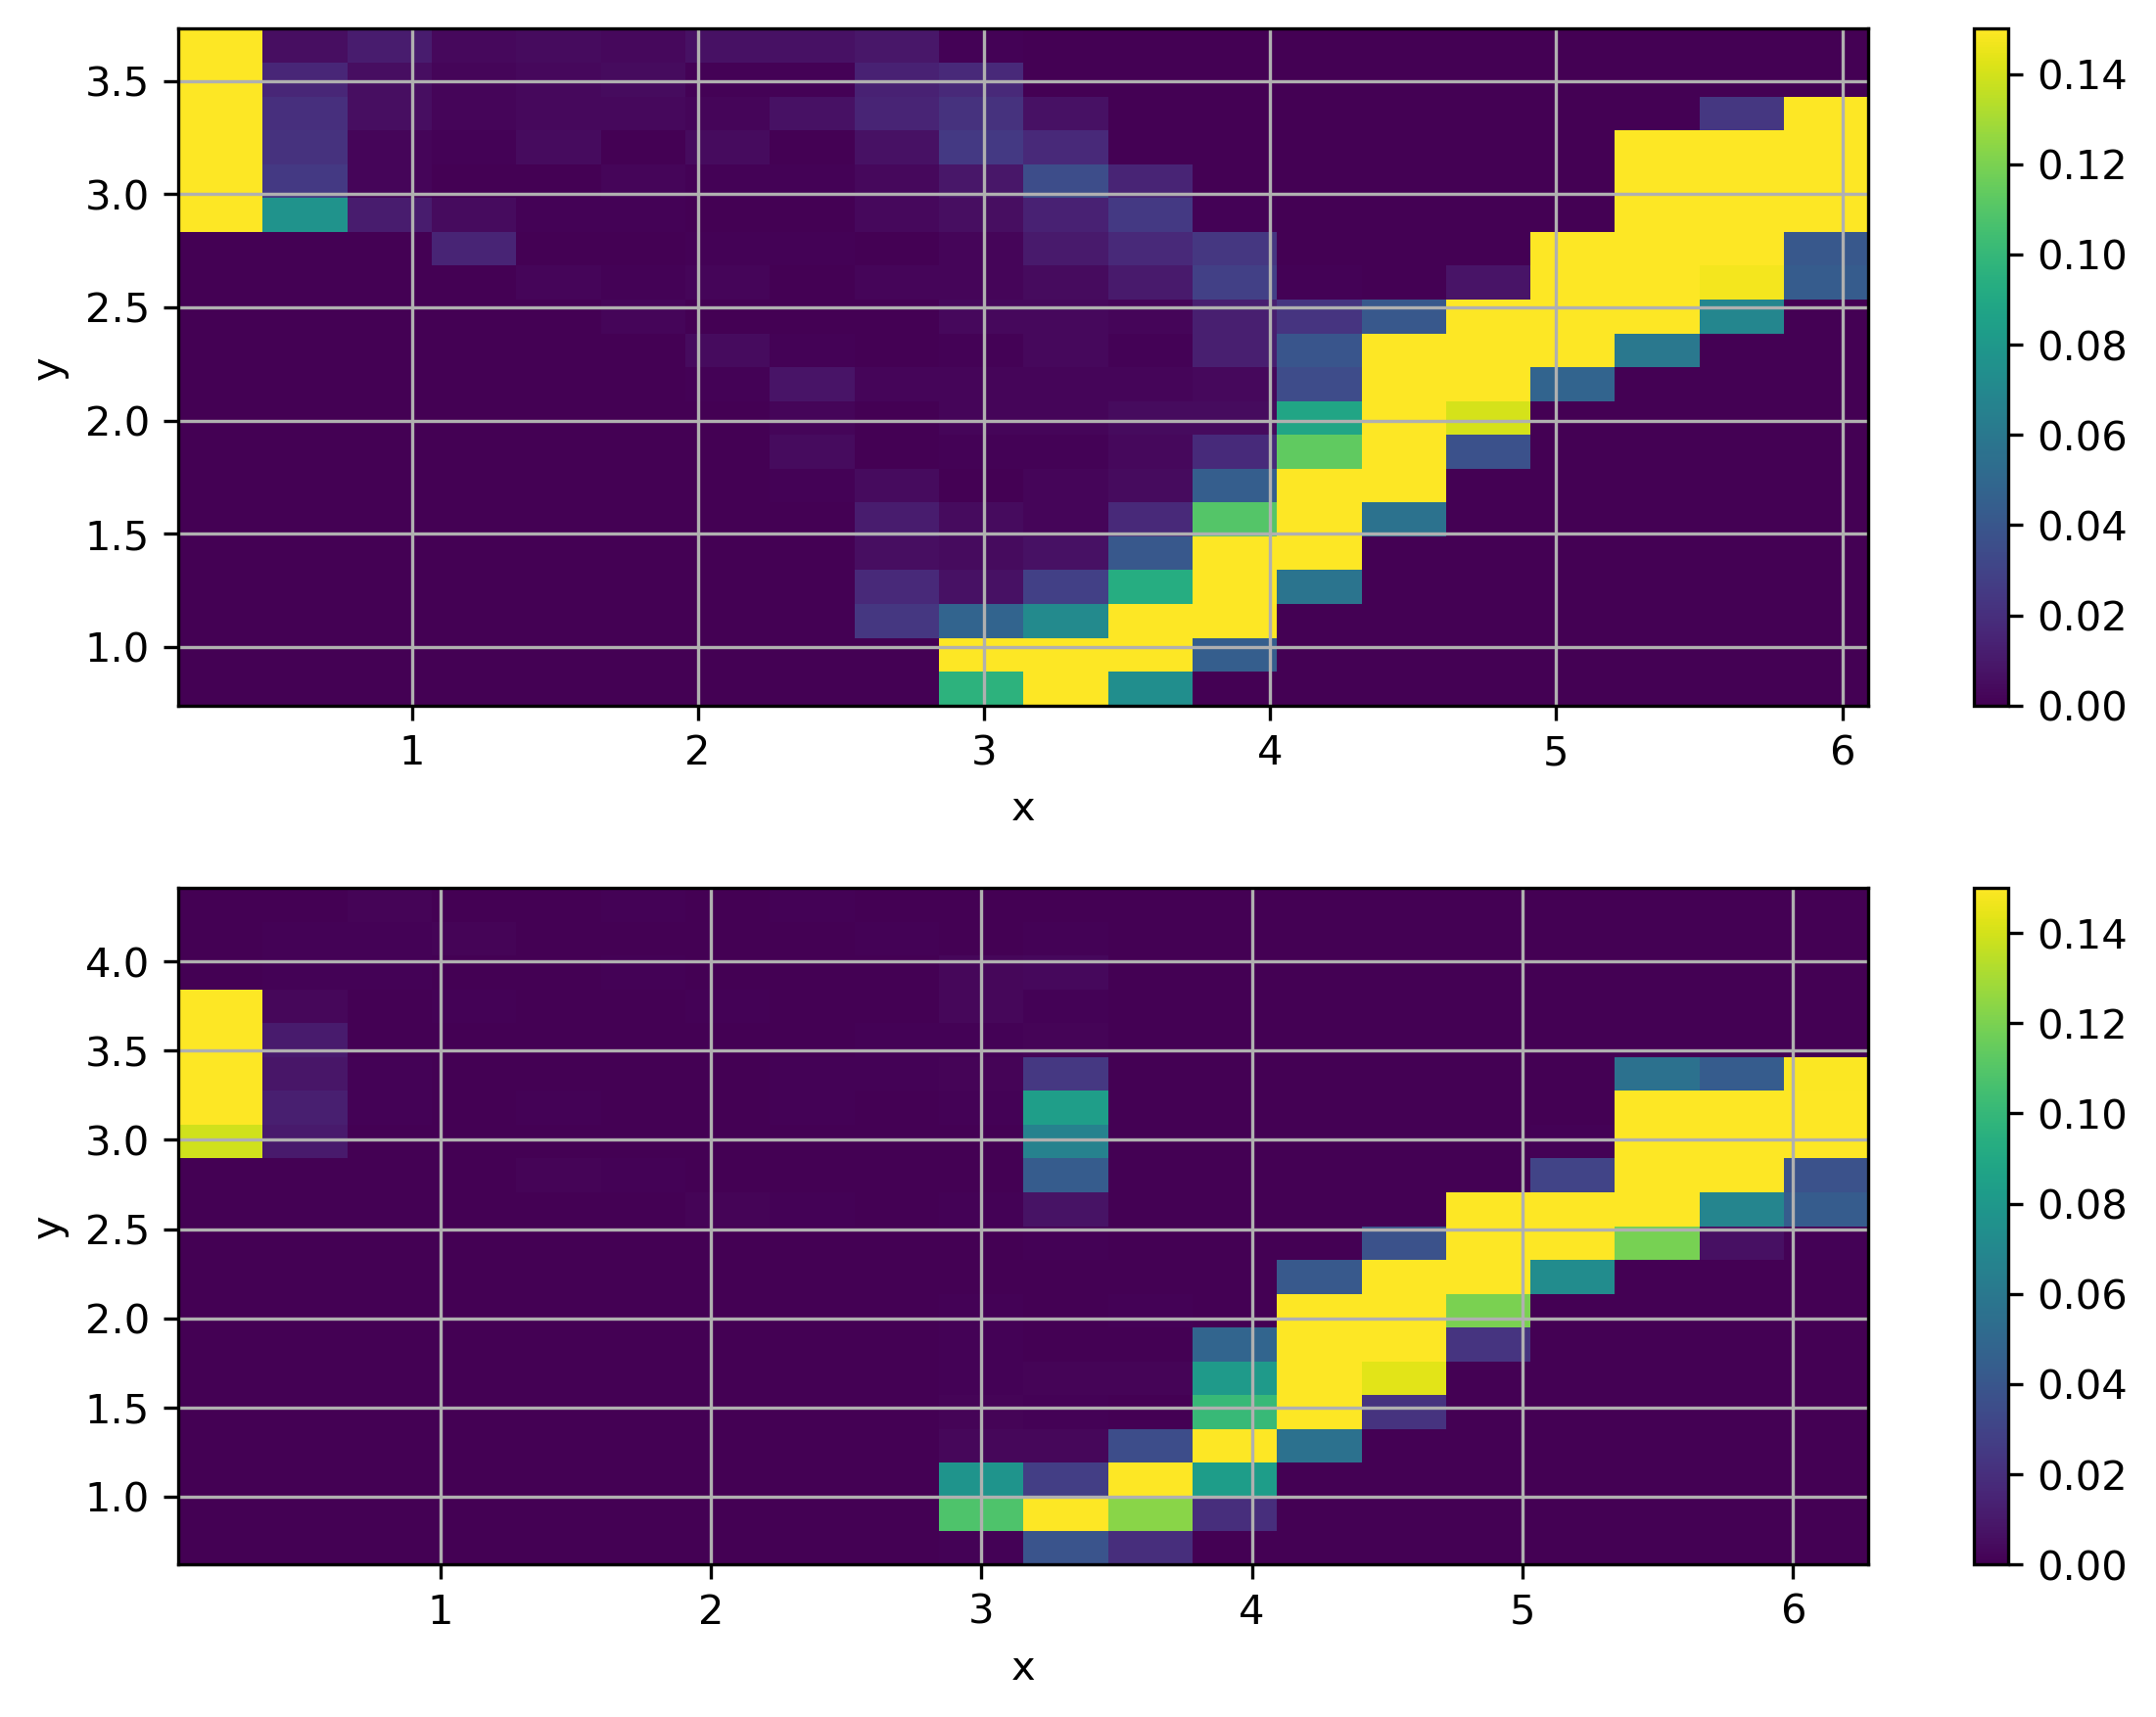

In [16]:
key = random.PRNGKey(0)
dict_num = 10
xpre = jnp.zeros(shape=[dict_num, predict_size, 2])
fref = jnp.zeros(shape=[dict_num, predict_size, 2])
for i in range(dict_num):
    xpre = xpre.at[i, :, :].set(SourceGenerator(rng_key = key, size = predict_size))
    key, _ = random.split(key, 2)
    fref = fref.at[i, :, :].set(TargetGenerator(rng_key = key, size = predict_size))
    key, _ = random.split(key, 2)
params = model.get_params(model.opt_state)
f_pred = jax.device_get(model.predict(params, xpre))

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
vmin = 0
vmax = 0.15
ax_top = axes[0]  
ax_bottom = axes[1]  

dict_show = random.choice(key, jnp.arange(dict_num), shape=([1]))
dict_show = dict_show[0]
hist2dplot(f_pred[dict_show, :, 0], f_pred[dict_show, :, 1], ax_top, 
          labels=['x', 'y'], vmin=vmin, vmax=vmax)
#ax_top.title.set_text("Outcome from Resnet")

hist2dplot(fref[dict_show, :, 0], fref[dict_show, :, 1], ax_bottom, 
          labels=['x', 'y'], vmin=vmin, vmax=vmax)
#ax_bottom.title.set_text("Outcome from Training data")
    
plt.tight_layout()
plt.savefig('Comparisons_between_outcome_and_trainingdata.eps', format='eps', dpi=300)
plt.show()